## Example Queries for Numerator

In this tutorial notebook, we utilize the Python API to query Kellogg's Numerator dataset hosted on Redivis. The API uses a web browser to authenticate Kellogg users via SSO, so no additional steps are required beyond installing the ```redivis``` Python module via pip. We also choose to view/manipulate the downloaded data using Pandas and Matplotlib, though there are many other options available as well (e.g., polars, seaborn, ggplot, dplyr, etc.)

Structured Query Language (SQL) is a nearly universal language for querying relational databases. Redivis uses Google's BigQuery as a backend for its cloud database design. These queries may need to be modified slightly to run on other databases as they use functions designed and optimized for BigQuery instead of AWS/Athena, for example.

In [1]:
import redivis
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
%matplotlib inline

## Example 1: Average daily price of a carton of eggs

In [86]:
with open("redivis/egg_prices.sql", "r") as f:
    egg_prices_sql = f.read()

display(Markdown(f"```sql\n{egg_prices_sql}\n```"))

```sql
-- WITH clause to precompute the latest batch date for each item from the item table
WITH item_batch AS (
  SELECT 
    item_id, 
    -- For each item, find the latest batch date (converted to date only)
    MAX(DATE(batch_date)) AS latest_batch_date
  FROM `standard_nmr_feed_item_table`
  GROUP BY item_id
),
-- WITH clause to precompute the latest batch date for each transaction date from the fact table
trans_batch AS (
  SELECT 
    transaction_date, 
    -- For each transaction date, find the latest batch date (converted to date only)
    MAX(DATE(batch_date)) as latest_batch_date
  FROM `standard_nmr_feed_fact_table`
  GROUP BY transaction_date
) 
SELECT 
  -- Convert the transaction_date to date format
  DATE(t.transaction_date) AS transaction_date, 
  AVG(t.item_unit_price) as avg_price,
  STDDEV(t.item_unit_price) as std_price,
  -- Calculate lower quartile price using approx quantiles
  APPROX_QUANTILES(t.item_unit_price, 100)[OFFSET(24)] as lq_price,
  -- Calculate median price using approx quantiles
  APPROX_QUANTILES(t.item_unit_price, 100)[OFFSET(49)] AS median_price,
  -- Calculate upper quartile price using approx quantiles
  APPROX_QUANTILES(t.item_unit_price, 100)[OFFSET(74)] AS uq_price
FROM `standard_nmr_feed_fact_table` AS t
-- Join to ensure we're using the latest batch date for each transaction date
JOIN trans_batch AS tb
  ON t.transaction_date = tb.transaction_date
  -- Only include fact table rows where the batch_date matches the latest batch date for that transaction_date
  AND DATE(t.batch_date) = tb.latest_batch_date
-- Join the item table to add item details for each fact record
JOIN `standard_nmr_feed_item_table` i
  ON i.item_id = t.item_id
-- Join to ensure we're using the latest batch date for each item record
JOIN item_batch ib
  ON i.item_id = ib.item_id
  -- Only include item table rows where the batch_date matches the latest batch date for that item
  AND DATE(i.batch_date) = ib.latest_batch_date  
WHERE 
  -- Filter to include only items belonging to the specific category 'isc_gro_dai_egg_cage_free'
  i.category_id = 'isc_gro_dai_egg_cage_free'
  -- Filter to include only items with '12' in the description
  AND i.item_description like '%12%'
-- Group results by transaction_date to calculate the aggregated statistics per day
GROUP BY transaction_date;

```

#### Step 1: querying the fact table

The ```standard_nmr_feed_item_table```,  or simply, the item table, contains information on every individual item purchased in the Numerator dataset. The data are categorized using a hierarchical index.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Level</th>
      <th>Description</th>
      <th>ID</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Sector</td>
      <td>Grocery</td>
      <td>isc_grocery</td>
    </tr>
    <tr>
      <td>Department</td>
      <td>Dairy</td>
      <td>isc_gro_dairy</td>
    </tr>
    <tr>
      <td>Major Category</td>
      <td>Eggs</td>
      <td>isc_gro_dai_eggs</td>
    </tr>
    <tr>
      <td>Category</td>
      <td>Cage Free Eggs</td>
      <td>isc_gro_dai_egg_cage_free</td>
    </tr>
    <tr>
      <td>Sub-category</td>
      <td></td>
      <td></td>
    </tr>
  </tbody>
</table>

We expect there to be quite a bit of variance in the prices of eggs based on the product type. In this example, we chose to only select cage-free eggs, however, there are many other categories that fall under the major category of eggs (i.e., hard-boiled, free-range, egg substitute, etc.). Including the major category in the filter along with the category is redundant, but we include it in this example in case the user wishes to look at a different category.

It's also important we are comparing prices of products with the same quantity of eggs. Unfortunately, obtaining the carton-size is not as trivial as the step before. Because this is just an example, we'll make a rough attempt at selecting out cartons with a dozen eggs by doing a grep search on the number "12". Naturally, this might miss product descriptions using abbreviations like "DZ" for dozen instead of "12ct" or may include descriptions with product IDs instead of counts, but we can adjust for those incorrect values by aggregating our data in a smart manner below.

#### Step 2: querying the fact table

All of the transactions are located in the facts table. In this case, a singular transaction is called a "basket" that has one row for every unique item included in the transaction.

To get all the transactions related to eggs, we join the previous query with the fact table on the item ID. We also join on batch date to ensure that we retrieve the correct version of the dataset. If we want to include data from 2018-2024, we have to include data from two different batches: (1) batch_date='2024-05-13' for all data from 2018-01-01 through 2023-12-31 and (2)batch_date='2024-10-21' for 2024-01-01 through 2024-09-30.

#### Step 3: aggregating the data

Our final step is to get the average daily prices. We show this in a couple different ways. We first group by transaction date and then take the mean and standard deviation of all prices. However, as we said before, we did not attempt to clean up our item list, so we naturally expect there to be outlier prices. A better measurement of the typical value and variance might instead be the median and interquartile range. The advantage of computing mean/STD over median/IQR is that it does not require the data to be sorted. It would be impractical to compute the exact median for a data set containing billions of records such as this, so luckily BigQuery has a function called APPROX_QUANTILES to provide an approximate these values without needing to sort the data.

### Downloading the data

Since our query only references table names, we have to invoke the organization (Kellogg) and dataset (Numerator) in the Python API prior to running the query. We'll run the query and convert it to a pandas dataframe. From there, we'll save it locally as a parquet file.

In [5]:
df = redivis.organization('kellogg').dataset('numerator')\
            .query(egg_prices_sql).to_pandas_dataframe()
df.to_parquet('egg_prices.parquet',index=False)
df.head()

Please authenticate with your Redivis account. Opening browser to:
https://redivis.com/oauth/authorize?requestedLogin=eyJpZCI6MTAxNTcsImVtYWlsIjoidHJhY2kuam9obnNvbi4zMkBnbWFpbC5jb20iLCJhdXRoZW50aWNhdGlvblR5cGUiOiJnb29nbGUiLCJJZGVudGl0eVByb3ZpZGVySWQiOm51bGwsIklkZW50aXR5UHJvdmlkZXIiOm51bGx9&user_code=fd2027cacc43de3fbfdc58acce417028


  0%|          | 0/2465 [00:00<?, ?it/s]

,transaction_date,avg_price,std_price,lq_price,median_price,uq_price
0,2023-07-06,3.23138,1.157503,2.59,2.79,3.69
1,2021-02-02,3.226848,0.928881,2.48,2.99,3.79
2,2022-04-09,3.01706,0.911014,2.48,2.77,3.49
3,2021-05-30,3.051657,0.909358,2.48,2.82,3.49
4,2019-06-26,3.199543,0.933504,2.48,2.99,3.79


### Plotting the data

We'll work off of the data we downloaded from disk. Before we plot, we want to make some modifications. If we want to create a line plot, we need to sort by transaction date so the lines are drawn between consecutive dates. We chose to aggregate the data at the day level; however, this looks very noisy. To make the plot look a little cleaner, we'll instead plot the data smoothed over a 7-day average. We'll also overplot the IQR as a lightly-shaded region to show the variance in prices.

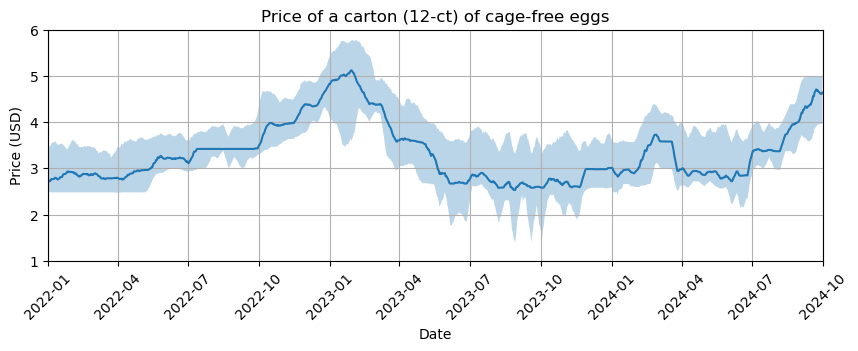

In [6]:
df = pd.read_parquet('egg_prices.parquet')\
        .sort_values(by='transaction_date')\
        .reset_index(drop=True)
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['median_price_7d'] = df['median_price'].rolling(7).mean()
df['lq_price_7d'] = df['lq_price'].rolling(7).mean()
df['uq_price_7d'] = df['uq_price'].rolling(7).mean()
df = df[df['transaction_date'].dt.year >= 2022].reindex()

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df['transaction_date'],df['median_price_7d'])
ax.fill_between(df['transaction_date'],df['lq_price_7d'],df['uq_price_7d'],alpha=0.3)
ax.set_xlim(pd.to_datetime('2022-01-01'),pd.to_datetime('2024-10-01'))
ax.set_ylim(1,6)
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.set_title('Price of a carton (12-ct) of cage-free eggs')
ax.tick_params(axis='x', rotation=45)
plt.savefig('egg_prices.png')
plt.show()

## Example 2: Social media influencer products

Often times, popular social media personalities will be sponsored by companies to help push product sales on their channels. In the past few years, there has been a boom in collagen dietary supplements sales primarily from social media marketing.

In [87]:
with open("redivis/collagen_demographics.sql", "r") as f:
    collagen_sql = f.read()

display(Markdown(f"```sql\n{collagen_sql}\n```"))

```sql
-- WITH clause to create temporary tables for the latest batch dates for items, transactions, and people

-- Get the most recent batch date for each item from the item table
WITH item_batch AS (
  SELECT 
    item_id, 
    -- For each item, find the latest batch_date (converted to a date)
    MAX(DATE(batch_date)) AS latest_batch_date
  FROM `standard_nmr_feed_item_table`
  GROUP BY item_id
),
-- Get the most recent batch date for each transaction date from the fact table
trans_batch AS (
  SELECT 
    transaction_date, 
    -- For each transaction date, find the latest batch_date (converted to a date)
    MAX(DATE(batch_date)) AS latest_batch_date
  FROM `standard_nmr_feed_fact_table`
  GROUP BY transaction_date
),
-- Get the most recent batch date for each user from the people table
people_batch AS (
  SELECT 
    user_id, 
    -- For each user, find the latest batch_date (converted to a date)
    MAX(DATE(batch_date)) AS latest_batch_date
  FROM `standard_nmr_feed_people_table`
  GROUP BY user_id
)

SELECT 
  t.transaction_date, 
  p.gender_app_user, 
  p.age_bucket, 
  SUM(t.item_quantity) AS units_sold
FROM `standard_nmr_feed_item_table` i
-- Join the fact table to link items with their transaction details using item_id
JOIN `standard_nmr_feed_fact_table` t
  ON i.item_id = t.item_id
-- Join the people table to attach user details (like gender and age bucket) using user_id from the fact table
JOIN `standard_nmr_feed_people_table` p
  ON p.user_id = t.user_id
-- Join the item_batch CTE to ensure we only use the latest batch data for each item
JOIN item_batch ib
  ON i.item_id = ib.item_id
  AND DATE(i.batch_date) = ib.latest_batch_date
-- Join the trans_batch CTE to ensure we only use the latest batch data for each transaction date
JOIN trans_batch tb 
  ON t.transaction_date = tb.transaction_date
  AND DATE(t.batch_date) = tb.latest_batch_date
-- Join the people_batch CTE to ensure we only use the latest batch data for each user
JOIN people_batch pb
  ON p.user_id = pb.user_id
  AND DATE(p.batch_date) = pb.latest_batch_date
WHERE 
  -- Filter to include only items that belong to the category 'isc_hea_vit_min_collagen'
  i.category_id = 'isc_hea_vit_min_collagen'
-- Group the results by transaction date, gender, and age bucket to sum the units sold
GROUP BY 1, 2, 3;

```

### Download the data

In [8]:
df = redivis.organization('kellogg').dataset('numerator')\
            .query(collagen_sql).to_pandas_dataframe()
df.to_parquet('collagen_demographics.parquet',index=False)
df.head()

  0%|          | 0/40711 [00:00<?, ?it/s]

,transaction_date,gender_app_user,age_bucket,units_sold
0,2023-04-10,Male,18-20,8.0
1,2024-06-02,Female,18-20,2.0
2,2021-11-06,Female,18-20,1.0
3,2024-05-16,Female,18-20,1.0
4,2022-11-30,Female,18-20,2.0


### Plotting the data

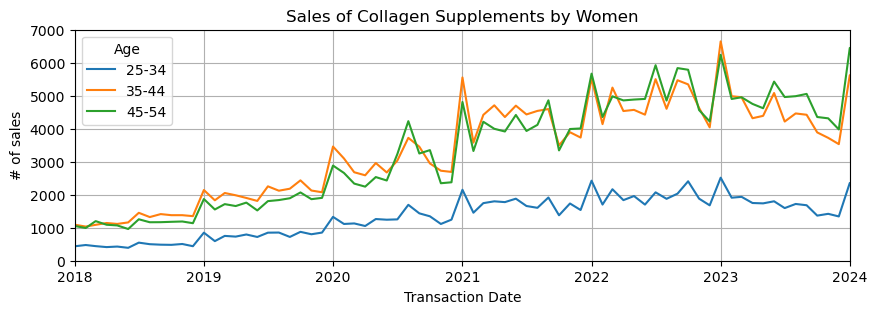

In [ ]:
df = pd.read_parquet('collagen_demographics.parquet')
df['month'] = df['transaction_date'].apply(lambda x: pd.Period(x,freq='M').start_time)

df = df[df['gender_app_user'].eq('Female') &
        df['age_bucket'].isin(['25-34','35-44','45-54'])].dropna()\
        .groupby(['month','age_bucket'])\
        .agg({'units_sold':'sum'}).reset_index()

fig, ax = plt.subplots(figsize=(10,3))

age_buckets = df['age_bucket'].unique()
for a in age_buckets:
    ax.plot(df.loc[df['age_bucket'].eq(a),'month'],
            df.loc[df['age_bucket'].eq(a),'units_sold'],
            label=a)
ax.legend(title='Age')
ax.set_xlim(pd.to_datetime('2018-01-01'),pd.to_datetime('2024-01-01'))
ax.set_ylim(0,7000)
ax.set_xlabel('Transaction Date')
ax.set_ylabel('# of sales')
ax.set_title('Monthly Sales of Collagen Supplements by Women')
ax.grid()
plt.savefig('collagen_demographics.png')
plt.show()

We do see a general trend of increasing sales over time for all age buckets.

## Example 3: Are alcohol sales affected by marijuana legalization?

For this example, we'll look at the alcohol sales in two adjacent counties in the St. Louis metro area:
- St. Clair County, Illinois
- St. Louis County, Missouri

The state of Illinois legalized recreational marijuana effective January 1, 2020 while marijuana remains illegal in Missouri. We expect alcohol sales to drop as it becomes a legal substitute to drinking.

Numerator has rough geographical data for the point of sale; however, we need supplementary data to categorize sales by county. Luckily, Redivis makes this really easy as there are several publicly-available datasets we can join with Numerator.

Let's take a quick look at Redivis's Demo dataset of US Political Boundaries, which includes two-dimensional shape data US states, counties, and congressional districts. Below is the query for selecting the two counties we are interested in.

In [88]:
with open("redivis/polygon.sql", "r") as f:
    polygon_sql = f.read()

display(Markdown(f"```sql\n{polygon_sql}\n```"))

```sql
  SELECT 
    c.geometry AS county_borders, 
    c.name as county_name, 
    s.name as state_name
  FROM `demo.us_political_boundaries.us_counties` c
  JOIN `demo.us_political_boundaries.us_states` s
  ON s.state = c.state
  WHERE (
    (s.name = 'Illinois' and c.name = 'St. Clair') OR
    (s.name = 'Missouri' and c.name = 'St. Louis'))
  AND c.lsad = 'County'
```

In [89]:
gdf = redivis.query(polygon_sql).to_geopandas_dataframe()
gdf

  0%|          | 0/2 [00:00<?, ?it/s]

,county_borders,county_name,state_name
0,"POLYGON ((-90.26372 38.52076, -90.25539 38.513...",St. Clair,Illinois
1,"POLYGON ((-90.26381 38.52055, -90.26368 38.520...",St. Louis,Missouri


Each row has a list of vertices corresponding to the borders of both counties. Let's see what they look like on a map.

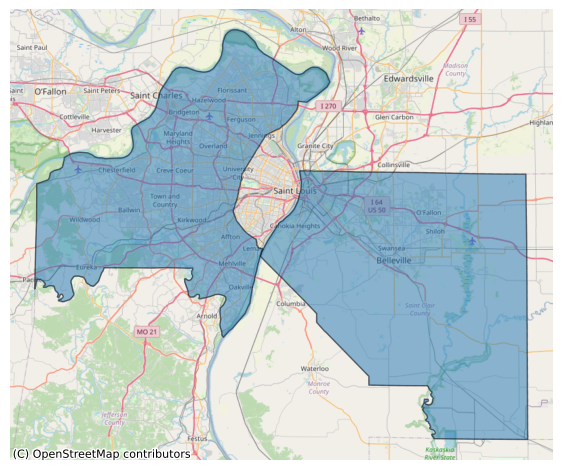

In [ ]:
import geopandas as gpd
import contextily as ctx

gdf_projected = gdf.to_crs(epsg=3857)

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(7, 7))

# Plot your polygons
gdf_projected.plot(ax=ax, alpha=0.5, edgecolor='k')

# Add a basemap (using, for example, Stamen Toner Lite)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Remove axis for a cleaner look
ax.set_axis_off()

# Save the static map to an image file if desired
plt.savefig('static_map.png', bbox_inches='tight', pad_inches=0)

# Display the map
plt.show()


In [90]:
with open("redivis/alcohol_sales_by_county.sql", "r") as f:
    alcohol_sql = f.read()

display(Markdown(f"```sql\n{alcohol_sql}\n```"))

```sql
-- CTE "poly": Selects county borders and names for two specific counties
WITH poly AS (
  SELECT 
    c.geometry AS county_borders, -- The geographic boundary of the county
    c.name AS county_name,        -- The county name
    s.name AS state_name          -- The state name
  FROM `demo.us_political_boundaries.us_counties` c
  -- Join to the states table to get state names corresponding to the county
  JOIN `demo.us_political_boundaries.us_states` s
    ON s.state = c.state
  WHERE (
    -- Filter to include only St. Clair County in Illinois or St. Louis County in Missouri
    (s.name = 'Illinois' AND c.name = 'St. Clair') OR
    (s.name = 'Missouri' AND c.name = 'St. Louis')
  )
  AND c.lsad = 'County'  -- Ensure the record represents a county
),
-- CTE "bbox": Computes a bounding box that covers the selected counties
bbox AS (
  SELECT 
    MIN(ST_BOUNDINGBOX(county_borders)[OFFSET(0)]) AS long_min, -- Smallest longitude among the county boxes
    MIN(ST_BOUNDINGBOX(county_borders)[OFFSET(1)]) AS lat_min,  -- Smallest latitude among the county boxes
    MAX(ST_BOUNDINGBOX(county_borders)[OFFSET(2)]) AS long_max, -- Largest longitude among the county boxes
    MAX(ST_BOUNDINGBOX(county_borders)[OFFSET(3)]) AS lat_max  -- Largest latitude among the county boxes
  FROM poly
),
-- CTE "item_batch": Retrieves the latest batch date for each item to ensure up-to-date item records
item_batch AS (
  SELECT 
    item_id, 
    MAX(DATE(batch_date)) AS latest_batch_date -- Latest date for each item
  FROM `kellogg.numerator.standard_nmr_feed_item_table`
  GROUP BY item_id
),
-- CTE "trans_batch": Retrieves the latest batch date for each transaction date to ensure up-to-date transaction records
trans_batch AS (
  SELECT 
    transaction_date, 
    MAX(DATE(batch_date)) AS latest_batch_date -- Latest date for each transaction date
  FROM `kellogg.numerator.standard_nmr_feed_fact_table`
  GROUP BY transaction_date
),
-- CTE "sales_bbox": Filters transactions based on geographic and other business criteria
sales_bbox AS (
  SELECT 
    t.transaction_date, 
    ST_GEOGPOINT(t.longitude, t.latitude) AS trans_geopoint, -- Converts longitude/latitude to a geography point
    t.item_total
  FROM `kellogg.numerator.standard_nmr_feed_item_table` i
  -- Join fact table on item_id to link item records with their transactions
  JOIN `kellogg.numerator.standard_nmr_feed_fact_table` t
    ON i.item_id = t.item_id
  -- Ensure using the most recent item record from the batch
  JOIN item_batch ib
    ON i.item_id = ib.item_id
    AND DATE(i.batch_date) = ib.latest_batch_date
  -- Ensure using the most recent transaction record from the batch
  JOIN trans_batch tb
    ON t.transaction_date = tb.transaction_date
    AND DATE(t.batch_date) = tb.latest_batch_date
  -- Join the bounding box to filter transactions that fall within the geographic extent of the selected counties
  JOIN bbox
    ON t.latitude BETWEEN bbox.lat_min AND bbox.lat_max
    AND t.longitude BETWEEN bbox.long_min AND bbox.long_max
  WHERE 
    -- Filter for transactions belonging to the specific department
    i.dept_id = 'isc_gro_bev_beer_wine_and_spirits'
    -- Include transactions between 2018 and 2022 (inclusive)
    AND EXTRACT(YEAR FROM DATE(t.transaction_date)) BETWEEN 2018 AND 2022
)
-- Final query: Aggregates sales by year, month, and county
SELECT 
  EXTRACT(YEAR FROM DATE(s.transaction_date)) AS trans_year,  -- Extracts the transaction year
  EXTRACT(MONTH FROM DATE(s.transaction_Date)) AS trans_month,   -- Extracts the transaction month
  p.county_name,                                               -- County name from the "poly" CTE
  p.state_name,                                                -- State name from the "poly" CTE
  SUM(s.item_total) AS total_sales                             -- Total sales aggregated by the groupings
FROM sales_bbox s
-- Join with the "poly" CTE to link transactions to county boundaries using spatial matching
JOIN poly p
  ON ST_COVERS(
       ST_BUFFER(p.county_borders, 2000), -- Create a 2000-meter buffer around the county borders for looser spatial matching
       ST_BUFFER(s.trans_geopoint, 2000)    -- Create a 2000-meter buffer around the transaction location
     )
WHERE 
  -- Further ensure that the county borders contain the exact transaction point
  ST_CONTAINS(p.county_borders, s.trans_geopoint)
GROUP BY 1, 2, 3, 4;

```

In [92]:
df = redivis.query(alcohol_sql).to_pandas_dataframe()
df.to_parquet('alcohol_sales_by_county.sql',index=False)
df.head()

  0%|          | 0/120 [00:00<?, ?it/s]

,trans_year,trans_month,county_name,state_name,total_sales
0,2022,11,St. Clair,Illinois,4702.56
1,2022,5,St. Clair,Illinois,4030.68
2,2018,9,St. Louis,Missouri,17492.87
3,2018,10,St. Clair,Illinois,2685.07
4,2019,10,St. Louis,Missouri,18746.56


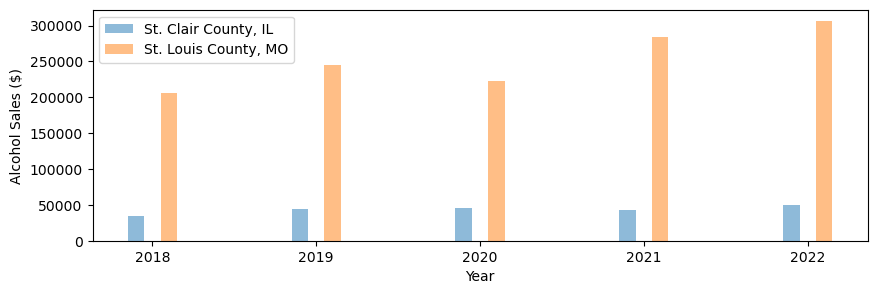

In [110]:
df = pd.read_parquet('alcohol_sales_by_county.sql')\
    .sort_values(by=['trans_year','trans_month'])\
    .groupby(['trans_year','county_name','state_name'])['total_sales'].sum()\
    .reset_index()

fig, ax = plt.subplots(figsize=(10,3))
ax.bar(df.loc[df['state_name'].eq('Illinois'),'trans_year']-0.1,
        df.loc[df['state_name'].eq('Illinois'),'total_sales'],
        alpha=0.5,width=0.1,label='St. Clair County, IL')
ax.bar(df.loc[df['state_name'].eq('Missouri'),'trans_year']+0.1,
        df.loc[df['state_name'].eq('Missouri'),'total_sales'],
        alpha=0.5,width=0.1,label='St. Louis County, MO')
ax.set_xlabel('Year')
ax.set_ylabel('Alcohol Sales ($)')
ax.legend()
ax.set_title('')
plt.savefig('alcohol_sales_by_county.png')
plt.show()
